In [1]:
import time
import scipy.io as scio
import numpy as np
from multiprocessing import Pool
import sys
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
from MDPD import utils, readers, MDPD

## Read Data

In [2]:
folder = "/media/vzhao/Data/MNIST"
mnist = readers.MNIST_Reader(folder, binarized=True)
train, labels = mnist.train, mnist.labels
_, dim, _ = train.shape

Extracting /media/vzhao/Data/MNIST/train-images-idx3-ubyte.gz
Extracting /media/vzhao/Data/MNIST/train-labels-idx1-ubyte.gz
Extracting /media/vzhao/Data/MNIST/t10k-images-idx3-ubyte.gz
Extracting /media/vzhao/Data/MNIST/t10k-labels-idx1-ubyte.gz


## Information residue as in raw data

In [3]:
nsample = 1000

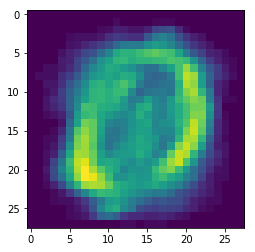

In [5]:
features, sigma = utils.Feature_Selection.MI_feature_ranking(train[:nsample,...])
plt.imshow(sigma[np.argsort(features)].reshape((28,28)))

Reference G statistis at [99, 95, 90, 75, 50] percentile
[0.005672433365072185, 0.003907363951625588, 0.0031256943155851613, 0.002054172467816158, 0.0011829869421876688]


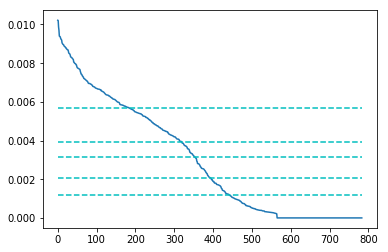

In [6]:
percentages = [99,95,90,75,50]
percentiles = [stats.chi2.ppf(x/100.,3) / (2 * nsample) for x in percentages]
print 'Reference G statistis at {} percentile'.format(percentages)
print percentiles

plt.plot(sigma/(dim - 1))
# plot reference G statistics
for foo in percentiles:
    plt.plot([0, len(sigma)], [foo, foo], 'c--')

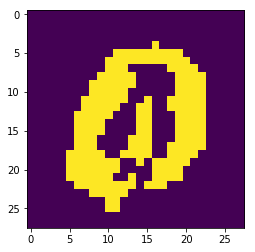

In [7]:
Ntop = 200
img = np.zeros(dim)
img[features[:Ntop]] = 1
plt.imshow(img.reshape((28,28)))

## Train a MDPD with the selected features

In [8]:
model1 = MDPD.MDPD()
model1.fit(train, ncomp=10, init='random', verbose=True, features=features[:Ntop], niter=50)

2018-04-02 15:21:49,902 : INFO : Training an MDPD with dimension 200, sample size 55000, vocab size 2 and the target number of components 10


In [9]:
model1.logW

array([-2.60503232, -2.07847858, -2.14629764, -2.32090337, -2.10165846,
       -2.63413508, -2.41826365, -2.07554472, -2.32987009, -2.52609588])

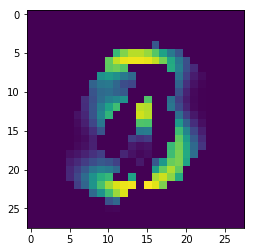

In [15]:
img = np.zeros(dim)
img[features[:Ntop]] = np.exp(model1.logC[:,0,1])
plt.imshow(img.reshape((28,28)))

In [13]:
foo.shape

(200,)